# Image Classification with Decision Trees

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import os
import csv

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection importRandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier


2023-04-16 17:57:25.199322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 17:57:25.436113: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-16 17:57:29.204746: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-16 17:57:29.204939: W tensorflow/strea

### Load Dataset

In [ ]:
%%time

# Load the compressed array from disk
images_mini = np.load('CNN_Xs_downsample_forvgg16.npz')['data']

CPU times: user 12 s, sys: 1.03 s, total: 13 s
Wall time: 13 s


In [ ]:
# load the labels from disk
with open('CNN_labels_downsampled_forvgg16.csv', 'r') as file:
    reader = csv.reader(file)
    labels_mini = list(reader)[0]
    labels_mini = [int(x) for x in labels_mini]
    y_mini= np.array(labels_mini)

In [ ]:
print('images_mini.shape:', images_mini.shape)
print('\nnumber of labels:', len(labels_mini))
print('\nnumber of positive cancer cases:', sum(labels_mini))

images_mini.shape: (5600, 224, 224, 3)

number of labels: 5600

number of positive cancer cases: 600


### Normalize

In [ ]:
print('Original max pixel value:', images_mini.max())
print('Confirm min pixel value is 0:', images_mini.min())

Original max pixel value: 255.0
Confirm min pixel value is 0: 0.0


In [ ]:
#Normalize image pixel values
images_mini_norm = images_mini / images_mini.max() 

In [ ]:
print('New max pixel value:', images_mini_norm.max())
print('Confirm min pixel value is 0:', images_mini_norm.min())

New max pixel value: 1.0
Confirm min pixel value is 0: 0.0


### Reshape

In [ ]:
images_mini_norm.shape

(5600, 224, 224, 3)

In [ ]:
arr_mean = np.mean(images_mini_norm, axis=-1)
arr_mean.shape
resized_images_mini = np.expand_dims(arr_mean, axis=-1)
resized_images_mini.shape

(5600, 224, 224, 1)

In [ ]:
print('Original max pixel value:', resized_images_mini.max())
print('Confirm min pixel value is 0:', resized_images_mini.min())

Original max pixel value: 1.0
Confirm min pixel value is 0: 0.0


## Settings

In [ ]:
random_state = 1234

In [ ]:
random.seed(random_state)
tf.random.set_seed(random_state)
np.random.seed(random_state)

### Inputs

In [ ]:
X= resized_images_mini
y = y_mini

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# reshape
X_train = np.reshape(X_train, (len(X_train), -1))
X_test = np.reshape(X_test, (len(X_test), -1))

## Build Model

In [ ]:
param_grid = {
    'max_depth': [1, 3, 6, 9, 12], 
    'min_samples_split': np.linspace(2, .1 * len(X_train), 10).astype(int),
    'max_features': np.linspace(.1, 1, 10),
    'criterion': ['gini', 'entropy'],
}


In [ ]:
dtc = DecisionTreeClassifier(
    random_state=random_state
)

In [ ]:
X_train.shape

(4480, 224, 224, 1)

In [ ]:
y_train.shape

(4480,)

In [ ]:
grid_search = RandomizedSearchCV(
    dtc, 
    param_distributions=param_dist, 
    cv=StratifiedKFold(5),
    scoring='f1',
    n_jobs=-1,
    verbose=20,
    n_iter=100,
    return_train_score=True,
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 4/5; 1/500] START criterion=entropy, max_depth=12, max_features=0.2, min_samples_split=2
[CV 4/5; 1/500] END criterion=entropy, max_depth=12, max_features=0.2, min_samples_split=2;, score=(train=0.744, test=0.520) total time=  54.1s
[CV 3/5; 4/500] START criterion=entropy, max_depth=3, max_features=0.9, min_samples_split=51
[CV 3/5; 4/500] END criterion=entropy, max_depth=3, max_features=0.9, min_samples_split=51;, score=(train=0.619, test=0.487) total time= 1.1min
[CV 1/5; 5/500] START criterion=gini, max_depth=6, max_features=0.2, min_samples_split=200
[CV 1/5; 5/500] END criterion=gini, max_depth=6, max_features=0.2, min_samples_split=200;, score=(train=0.555, test=0.494) total time=  21.7s
[CV 2/5; 5/500] START criterion=gini, max_depth=6, max_features=0.2, min_samples_split=200
[CV 2/5; 5/500] END criterion=gini, max_depth=6, max_features=0.2, min_samples_split=200;, score=(train=0.567, test=0.537) total time=  22

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 3, 6, 9, 12],
                                        'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'min_samples_split': array([  2,  51, 101, 150, 200, 249, 299, 348, 398, 448])},
                   return_train_score=True, scoring='roc_auc', verbose=20)

In [ ]:
# print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'min_samples_split': 249, 'max_features': 0.1, 'max_depth': 9, 'criterion': 'entropy'}
Best Score: 0.5662995034768815


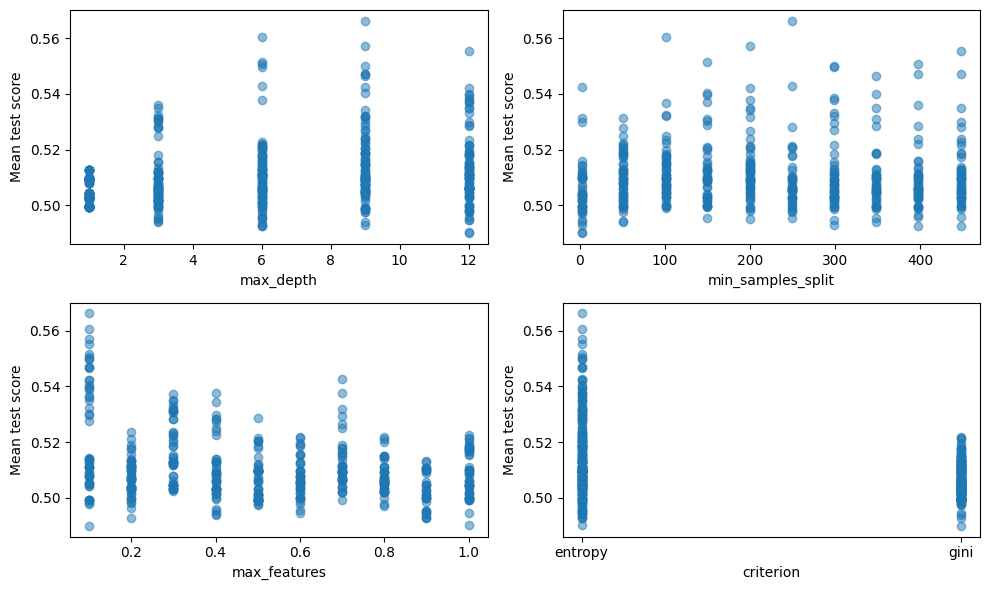

In [ ]:
params = grid_search.cv_results_['params']
scores = grid_search.cv_results_['mean_test_score']


import seaborn as sns
for param_name in params[0].keys():
    # Extract the scores and hyperparameter values for the current parameter
    
    values = [pdict[param_name] for pdict in params]
    
    # Create a boxplot
    plt.figure()
    sns.boxplot(x=values, y=scores)
    plt.xlabel(param_name)
    plt.ylabel('f1_score')
    plt.show()

### Scoring

In [ ]:
# grid_search.best_params_
# hyperparam = {
#     'min_samples_split': 249,
#     'max_features': 0.1,
#     'max_depth': 9,
#     'criterion': 'entropy'
# }


hyperparam = {
    'min_samples_split': 249,
    'max_features': 0.1,
    'max_depth': 9,
    'criterion': 'entropy'
}

In [ ]:
tuned_dtc = DecisionTreeClassifier(
    random_state=random_state,
    **hyperparam, #grid_search.best_params_
)

In [ ]:
tuned_dtc.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=9, max_features=0.1,
                       min_samples_split=249, random_state=1234)

In [ ]:
train_acc = tuned_dtc.score(X_train, y_train)
print(f"Train accuracy score: {train_acc:.3f}")

# Evaluate the test accuracy
test_cc = tuned_dtc.score(X_test, y_test)
print(f"Test accuracy score: {test_cc:.3f}")

Train accuracy score: 0.896
Test accuracy score: 0.891


In [ ]:
y_pred_train = tuned_dtc.predict(X_train)
y_pred_test = tuned_dtc.predict(X_test)

In [ ]:
train_roc = roc_auc_score(y_train, y_pred_train)
print(f"Train ROC_AUC score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = roc_auc_score(y_test, y_pred_test)
print(f"Test ROC_AUC score: {test_roc:.3f}")

Train ROC_AUC score: 0.520
Test ROC_AUC score: 0.499


In [ ]:
train_roc = precision_score(y_train, y_pred_train)
print(f"Train precision score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = precision_score(y_test, y_pred_test)
print(f"Test precision score: {test_roc:.3f}")

Train precision score: 0.833
Test precision score: 0.000
Train recall score: 0.042
Test recall score: 0.000


In [ ]:
train_roc = recall_score(y_train, y_pred_train)
print(f"Train recall score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = recall_score(y_test, y_pred_test)
print(f"Test recall score: {test_roc:.3f}")

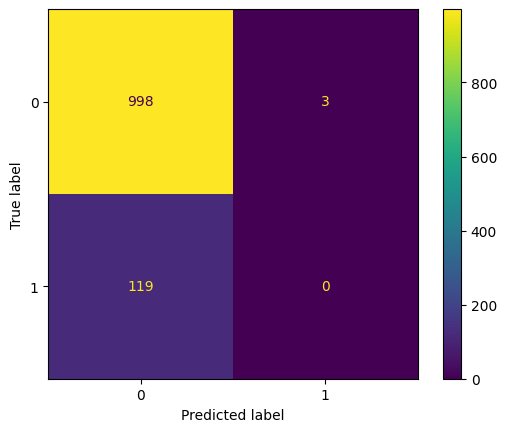

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tuned_clf.classes_
)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3999
           1       0.83      0.04      0.08       481

    accuracy                           0.90      4480
   macro avg       0.86      0.52      0.51      4480
weighted avg       0.89      0.90      0.85      4480



In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1001
           1       0.00      0.00      0.00       119

    accuracy                           0.89      1120
   macro avg       0.45      0.50      0.47      1120
weighted avg       0.80      0.89      0.84      1120



In [ ]:
from sklearn.metrics import f1_score
train_roc = f1_score(y_train, y_pred_train)
print(f"Train f1 score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = f1_score(y_test, y_pred_test)
print(f"Test f1 score: {test_roc:.3f}")

Train f1 score: 0.079
Test f1 score: 0.000
